<a href="https://www.kaggle.com/code/sharanharsoor/pytorch-vgg-16-resnet-and-models?scriptVersionId=127929132" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction.

1. Loading dataset (CIFAR10) - Transforming images
2. VGG-16 with modification to network head
3. Using pre-trained models
4. Storing intermediate models
5. Resnet
6. Inception v3 <cr>

Most of the concepts explained in this Notebook are learnt from course [Deep Learning](https://padhai.onefourthlabs.in/courses/dl-feb-2019)

In [1]:
! pip3 install torch torchvision

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Dataset, transforms, and visualisation

In [4]:
# Data Augumentation. 

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),  # crop image at random and resizes it to 224.
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
num_classes = 10
batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [7]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
5


In [8]:
def imshow(img, title):
    npimg = img.numpy() / 2 + 0.5 # converting the image to to numpy and un-normalise it.
    plt.figure(figsize=(batch_size, 1))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [9]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

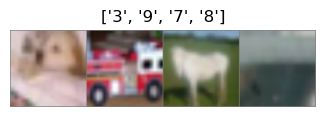

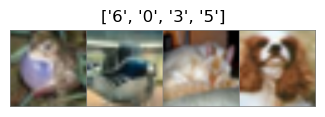

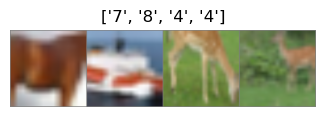

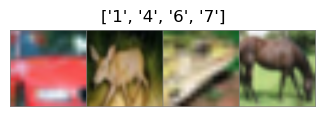

In [10]:
for i in range(4):
    show_batch_images(trainloader)

#  VGG-16
https://pytorch.org/vision/main/models/vgg.html

In [11]:
from torchvision import models

In [12]:
vgg = models.vgg16_bn() #bn stands for batch normalization.

In [13]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [14]:
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [15]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [16]:
# last layer has 1000 classes, but for CIFAR10 has only 10 label outputs, changing the same with below code. 

final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1] # keeping all the layers expect the last one
mod_classifier.extend([nn.Linear(final_in_features, num_classes)]) # extending the last layer with the requiered number of class. 
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [17]:
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# Train CIFAR10

In [18]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [19]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [20]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [21]:
%%time 

loss_epoch_arr = []
max_epochs = 1
clip_value = 5

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vgg.parameters(), clip_value)
        opt.step()
        
        # below steps ensures that the memory usage in the GPU is optimised. 
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))
    
# change max_epochs value to > 1 
#plt.plot(loss_epoch_arr) 
#plt.show()

Iteration: 0/3125, Loss: 2.28
Iteration: 100/3125, Loss: 2.28
Iteration: 200/3125, Loss: 1.71
Iteration: 300/3125, Loss: 1.76
Iteration: 400/3125, Loss: 2.09
Iteration: 500/3125, Loss: 1.86
Iteration: 600/3125, Loss: 2.43
Iteration: 700/3125, Loss: 2.17
Iteration: 800/3125, Loss: 2.30
Iteration: 900/3125, Loss: 2.29
Iteration: 1000/3125, Loss: 1.90
Iteration: 1100/3125, Loss: 1.87
Iteration: 1200/3125, Loss: 1.81
Iteration: 1300/3125, Loss: 2.10
Iteration: 1400/3125, Loss: 1.45
Iteration: 1500/3125, Loss: 1.73
Iteration: 1600/3125, Loss: 1.85
Iteration: 1700/3125, Loss: 1.58
Iteration: 1800/3125, Loss: 2.00
Iteration: 1900/3125, Loss: 1.78
Iteration: 2000/3125, Loss: 2.06
Iteration: 2100/3125, Loss: 1.59
Iteration: 2200/3125, Loss: 2.13
Iteration: 2300/3125, Loss: 2.06
Iteration: 2400/3125, Loss: 1.86
Iteration: 2500/3125, Loss: 1.85
Iteration: 2600/3125, Loss: 1.64
Iteration: 2700/3125, Loss: 1.99
Iteration: 2800/3125, Loss: 1.98
Iteration: 2900/3125, Loss: 1.99
Iteration: 3000/3125, 

# Freeze layers of Convolutional Operations
The above vgg16 module is taking a long time to train. To reduce the training time use a pre-trained model (the weights of the models have been saved). The approach is to freeze some layers and train the required layer to reduce the training time. 

In [22]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [23]:
# downloading the pre-trained model. Please note VGGnet is trained for ImageNet dataset that had 1000 labels.

vgg = models.vgg16_bn(pretrained=True)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [24]:
# preventing the weights updates via back propegation.

for param in vgg.parameters():
    param.requires_grad = False

In [25]:
# Adding the final layes as a linear layer with num of classes.
# only this layer will have requires_grad as true, only weights of this layer get updated.

final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

In [26]:
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [27]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [28]:
%%time 

loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))

# change max_epochs value to > 1 
#plt.plot(loss_epoch_arr) 
#plt.show()

Iteration: 0/3125, Loss: 2.47
Iteration: 100/3125, Loss: 2.38
Iteration: 200/3125, Loss: 1.96
Iteration: 300/3125, Loss: 2.29
Iteration: 400/3125, Loss: 2.83
Iteration: 500/3125, Loss: 1.60
Iteration: 600/3125, Loss: 1.80
Iteration: 700/3125, Loss: 2.28
Iteration: 800/3125, Loss: 1.83
Iteration: 900/3125, Loss: 2.68
Iteration: 1000/3125, Loss: 0.66
Iteration: 1100/3125, Loss: 0.97
Iteration: 1200/3125, Loss: 1.20
Iteration: 1300/3125, Loss: 3.56
Iteration: 1400/3125, Loss: 1.98
Iteration: 1500/3125, Loss: 2.77
Iteration: 1600/3125, Loss: 1.03
Iteration: 1700/3125, Loss: 3.12
Iteration: 1800/3125, Loss: 2.30
Iteration: 1900/3125, Loss: 2.72
Iteration: 2000/3125, Loss: 1.98
Iteration: 2100/3125, Loss: 2.91
Iteration: 2200/3125, Loss: 1.44
Iteration: 2300/3125, Loss: 1.66
Iteration: 2400/3125, Loss: 2.37
Iteration: 2500/3125, Loss: 2.84
Iteration: 2600/3125, Loss: 2.39
Iteration: 2700/3125, Loss: 1.97
Iteration: 2800/3125, Loss: 2.24
Iteration: 2900/3125, Loss: 2.20
Iteration: 3000/3125, 

# With model copies (Checkpoint)

In [29]:
import copy

In [30]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(vgg.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())

# change max_epochs value to > 1 
#plt.plot(loss_epoch_arr) 
#plt.show()

Min loss 1.55
Iteration: 0/3125, Loss: 1.55
Min loss 1.28
Min loss 1.24
Min loss 1.07
Min loss 1.00
Iteration: 100/3125, Loss: 1.63
Min loss 1.00
Min loss 0.99
Min loss 0.90
Iteration: 200/3125, Loss: 2.27
Min loss 0.85
Iteration: 300/3125, Loss: 3.23
Min loss 0.83
Iteration: 400/3125, Loss: 2.94
Iteration: 500/3125, Loss: 1.89
Iteration: 600/3125, Loss: 2.07
Iteration: 700/3125, Loss: 1.85
Iteration: 800/3125, Loss: 2.57
Min loss 0.76
Iteration: 900/3125, Loss: 1.60
Min loss 0.73
Iteration: 1000/3125, Loss: 2.26
Min loss 0.71
Iteration: 1100/3125, Loss: 2.44
Iteration: 1200/3125, Loss: 1.83
Iteration: 1300/3125, Loss: 2.29
Min loss 0.70
Iteration: 1400/3125, Loss: 2.19
Iteration: 1500/3125, Loss: 2.96
Iteration: 1600/3125, Loss: 2.55
Min loss 0.62
Iteration: 1700/3125, Loss: 3.29
Iteration: 1800/3125, Loss: 3.83
Iteration: 1900/3125, Loss: 2.14
Iteration: 2000/3125, Loss: 2.30
Iteration: 2100/3125, Loss: 1.73
Iteration: 2200/3125, Loss: 2.21
Iteration: 2300/3125, Loss: 1.81
Iteration:

In [31]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))

44.9 44.99


# ResNet Model
https://pytorch.org/vision/stable/models/resnet.html

In [32]:
resnet = models.resnet18(pretrained=True)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [33]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
for param in resnet.parameters():
    param.requires_grad = False

In [35]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

In [36]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [37]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr=0.01)

In [38]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(resnet.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, resnet), evaluation(trainloader, resnet)))
    
    
# change max_epochs value to > 1 
#plt.plot(loss_epoch_arr) 
#plt.show()

Min loss 2.65
Iteration: 0/3125, Loss: 2.65
Min loss 2.38
Min loss 2.36
Min loss 2.33
Min loss 2.25
Min loss 2.23
Min loss 2.20
Min loss 2.04
Min loss 2.04
Min loss 1.97
Min loss 1.84
Min loss 1.81
Min loss 1.65
Min loss 1.60
Iteration: 100/3125, Loss: 1.96
Min loss 1.56
Min loss 1.56
Min loss 1.53
Min loss 1.50
Min loss 1.41
Min loss 1.37
Min loss 1.31
Min loss 1.27
Min loss 1.25
Iteration: 200/3125, Loss: 1.54
Min loss 1.24
Min loss 1.00
Iteration: 300/3125, Loss: 1.51
Min loss 1.00
Iteration: 400/3125, Loss: 1.43
Min loss 0.97
Iteration: 500/3125, Loss: 1.23
Min loss 0.92
Iteration: 600/3125, Loss: 1.67
Min loss 0.90
Iteration: 700/3125, Loss: 1.65
Min loss 0.87
Min loss 0.83
Iteration: 800/3125, Loss: 1.06
Min loss 0.82
Min loss 0.79
Iteration: 900/3125, Loss: 1.68
Min loss 0.72
Iteration: 1000/3125, Loss: 1.37
Iteration: 1100/3125, Loss: 1.44
Min loss 0.64
Iteration: 1200/3125, Loss: 1.11
Iteration: 1300/3125, Loss: 1.63
Iteration: 1400/3125, Loss: 1.99
Iteration: 1500/3125, Loss:

In [39]:
resnet.load_state_dict(best_model)
print(evaluation(trainloader, resnet), evaluation(testloader, resnet))

55.054 54.7


# Inception Model
https://pytorch.org/vision/stable/models/inception.html

In [40]:
inception = models.inception_v3(pretrained=True)
print(inception)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [41]:
for param in inception.parameters():
    param.requires_grad = False

In [42]:
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

In [43]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])


In [44]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [45]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


In [46]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [47]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [48]:
batch_size=16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [49]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr=0.01)

In [50]:
def evaluation_inception(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, aux_outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [51]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs, aux_outputs = inception(inputs)
        loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(inception.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation_inception(testloader, inception), 
        evaluation_inception(trainloader, inception)))
    
    
# change max_epochs value to > 1 
#plt.plot(loss_epoch_arr) 
#plt.show()

Min loss 3.00
Iteration: 0/3125, Loss: 3.00
Min loss 2.96
Min loss 2.95
Min loss 2.86
Min loss 2.86
Min loss 2.83
Min loss 2.82
Min loss 2.72
Min loss 2.72
Min loss 2.63
Min loss 2.59
Min loss 2.58
Iteration: 100/3125, Loss: 2.59
Min loss 2.48
Min loss 2.42
Min loss 2.41
Min loss 2.34
Iteration: 200/3125, Loss: 2.81
Min loss 2.31
Min loss 2.22
Min loss 2.17
Min loss 2.04
Iteration: 300/3125, Loss: 2.39
Min loss 2.02
Min loss 1.88
Iteration: 400/3125, Loss: 2.01
Min loss 1.82
Iteration: 500/3125, Loss: 2.09
Min loss 1.75
Min loss 1.53
Iteration: 600/3125, Loss: 2.23
Iteration: 700/3125, Loss: 2.22
Iteration: 800/3125, Loss: 2.20
Min loss 1.47
Min loss 1.41
Iteration: 900/3125, Loss: 1.41
Min loss 1.33
Iteration: 1000/3125, Loss: 1.98
Iteration: 1100/3125, Loss: 2.05
Min loss 1.30
Iteration: 1200/3125, Loss: 1.73
Iteration: 1300/3125, Loss: 1.86
Iteration: 1400/3125, Loss: 1.71
Iteration: 1500/3125, Loss: 2.33
Min loss 1.23
Iteration: 1600/3125, Loss: 2.13
Iteration: 1700/3125, Loss: 1.5

In [52]:
inception.load_state_dict(best_model)
print(evaluation_inception(trainloader, inception), evaluation_inception(testloader, inception))

47.108 46.17


# END 